In [2]:
import sys
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv

from IPython.display import Image
from scipy import optimize



from tyssue import config, Sheet, SheetGeometry, History, EventManager
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

C++ extension are not available for this version
collision solver could not be imported You may need to install CGAL and re-install tyssue


In [3]:
def length_elasticity_range(cellmap, lower_length_elasticity, higher_length_elasticity):
    for edge in range(len(cellmap.edge_df)):
        newValue = random.randrange(lower_length_elasticity, higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = newValue         
    return cellmap

In [4]:
def change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity,
                 prefered_area, lower_length_elasticity, higher_length_elasticity, line_nought, endTime):
    
    cellmap_original.face_df["face_elasticity"] = face_elasticity
    cellmap_original.face_df["prefered_area"] = prefered_area
    cellmap_original.edge_df["prefered_length"] = line_nought
    #cellmap_original.edge_df["length_elasticity"] = length_elasticity

    cellmap_original.vert_df["viscosity"] = 1   
    
    cellmap_original = length_elasticity_range(cellmap_original, lower_length_elasticity, higher_length_elasticity)

    solver1 = EulerSolver(cellmap_original, geom_original, model_original, history=history_original, auto_reconnect=True)
    res1 = solver1.solve(tf=endTime, dt=0.05)
    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]
    

In [5]:
## Definition of the sheet
geom_original  = SheetGeometry # This may need to change
#model = PlanarModel # This may need to change
model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

cellmap_original = Sheet.planar_sheet_3d('cellmap', 10, 10, 1, 1) # This may need to change

history_original = History(cellmap_original, extra_cols={"edge":["dx", "dy"]})


cellmap_original.sanitize ( trim_borders=True, order_edges=True )

geom.update_all(cellmap_original)

cellmap_original.update_specs(model_original.specs)


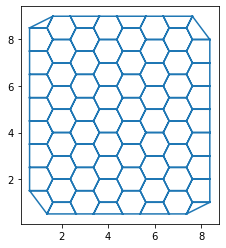

In [6]:
fig, ax = sheet_view(cellmap_original, ['y', 'x'], mode='quick')

## Homeostasis

In [7]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, face_elasticity = 0.05, prefered_area = 3, 
                                                        lower_length_elasticity = 900, higher_length_elasticity = 4800, line_nought = 1 , endTime = 10)


area =
2.818837721095861
face elasticity =
0.049999999999999996
prefered length =
1.0


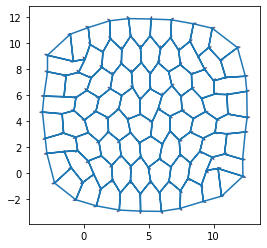

In [8]:
fig, ax = plot_forces(cellmap_H, geom_H, model_H, ['x', 'y'], 1)
print('area =')
print(cellmap_H.face_df["area"].mean())
print('face elasticity =')
print(cellmap_H.face_df["face_elasticity"].mean())
print('prefered length =')
print(cellmap_H.edge_df["prefered_length"].mean())

In [13]:
cellmap_H.edge_df

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,uz,is_valid,rx,ry,rz,phi,sub_area,length_elasticity,prefered_length,sub_vol
edge,,,,,,,,,,,,,,,,,,,,,
0,51,1.177022,1.440841,0,21,0.553413,1.330322,-0.604306,-2.027600,-0.050893,...,0.0,True,0.356936,-1.268823,0.0,-1.030377,0.588511,0.2977,1,-2.354045
1,52,1.084504,1.446264,0,51,-0.902203,1.130358,-0.050893,-0.697278,-0.953096,...,0.0,True,0.910349,0.061499,0.0,0.321751,0.542252,0.1552,1,-2.169009
2,20,1.520256,1.741109,0,52,-1.283576,-1.176390,-0.953096,0.433080,-2.236672,...,0.0,True,0.008145,1.191857,0.0,1.892547,0.760128,0.1999,1,-3.040512
3,21,1.612774,2.077022,0,20,1.632366,-1.284290,-2.236672,-0.743310,-0.604306,...,0.0,True,-1.275430,0.015467,0.0,2.944197,0.806387,0.2715,1,-3.225548
4,140,1.670764,1.654064,1,21,1.586055,-0.469424,-0.604306,-2.027600,0.981749,...,0.0,True,-1.092227,-0.730143,0.0,-2.356194,0.835382,0.3420,1,-3.341529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,101,1.050750,1.370560,70,103,-0.274341,-1.342822,8.450209,11.501507,8.175868,...,0.0,True,-0.536630,1.203438,0.0,2.356194,0.525375,0.4101,1,-2.101500
392,72,0.947688,1.337441,71,102,0.912770,-0.977547,9.614566,9.675919,10.527336,...,0.0,True,-0.850926,-0.126941,0.0,-2.819842,0.473844,0.4385,1,-1.895377
393,71,1.501131,1.627811,71,72,1.304608,0.973533,10.527336,8.698372,11.831944,...,0.0,True,0.061844,-1.104488,0.0,-1.249046,0.750565,0.2095,1,-3.002262


In [35]:
cellmap_H.edge_df[(cellmap_H.edge_df["trgt"] == 51) | (cellmap_H.edge_df["srce"] == 51)]

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,uz,is_valid,rx,ry,rz,phi,sub_area,length_elasticity,prefered_length,sub_vol
edge,,,,,,,,,,,,,,,,,,,,,
0,51,1.177022,1.440841,0,21,0.553413,1.330322,-0.604306,-2.027600,-0.050893,...,0.0,True,0.356936,-1.268823,0.0,-1.030377,0.588511,0.2977,1,-2.354045
1,52,1.084504,1.446264,0,51,-0.902203,1.130358,-0.050893,-0.697278,-0.953096,...,0.0,True,0.910349,0.061499,0.0,0.321751,0.542252,0.1552,1,-2.169009
7,51,0.843365,1.049009,1,122,-0.834246,-0.635966,0.783353,-0.061312,-0.050893,...,0.0,True,0.295432,1.236145,0.0,1.570796,0.421682,0.2322,1,-1.686730
8,21,1.048943,1.440841,1,51,-0.553413,-1.330322,-0.050893,-0.697278,-0.604306,...,0.0,True,-0.538814,0.600179,0.0,2.677945,0.524472,0.4306,1,-2.097886
46,51,0.953557,1.446264,10,52,0.902203,-1.130358,-0.953096,0.433080,-0.050893,...,0.0,True,-0.649491,-0.243182,0.0,-2.498092,0.476778,0.2698,1,-1.907114
47,122,1.306587,1.049009,10,51,0.834246,0.635966,-0.050893,-0.697278,0.783353,...,0.0,True,0.252712,-1.373539,0.0,-1.570796,0.653293,0.4663,1,-2.613173


In [ ]:
cellmap_H.edge_df.groupby(h

## Expansion phase

In [9]:
[cellmap_E, geom_E, model_E, history_E] = change_specs(cellmap_H, geom_H, model_H, history_H, face_elasticity = 0.05, prefered_area = 8, 
                                                        lower_length_elasticity = 100, higher_length_elasticity = 4000, line_nought = 1, endTime = 30)

area =
7.839846401482433
face elasticity =
0.049999999999999996
prefered length =
1.0


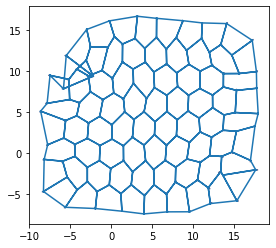

In [10]:
fig, ax = plot_forces(cellmap_E, geom_E, model_E, ['x', 'y'], 1)
print('area =')
print(cellmap_E.face_df["area"].mean())
print('face elasticity =')
print(cellmap_E.face_df["face_elasticity"].mean())
print('prefered length =')
print(cellmap_E.edge_df["prefered_length"].mean())

In [11]:
print(cellmap_E.edge_df["length_elasticity"].mean())

0.19481439393939395
